In [3]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import ExactEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

In [4]:
driver = PySCFDriver(atom='H .0 .0 -0.6; Li .0 .0 0.6',
                     unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
molecule = driver.run()

print('Hartree-Fock energy: {}'.format(molecule.hf_energy))
print('Nuclear repulsion energy: {}'.format(molecule.nuclear_repulsion_energy))
print('Number of molecular orbitals: {}'.format(molecule.num_orbitals))
print('Number of alpha electrons: {}'.format(molecule.num_alpha))
print('Number of beta electrons: {}'.format(molecule.num_beta))

Hartree-Fock energy: -7.835615825556919
Nuclear repulsion energy: 1.3229430273
Number of molecular orbitals: 6
Number of alpha electrons: 2
Number of beta electrons: 2


In [5]:
core = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
                   two_qubit_reduction=True, freeze_core=True,
                   orbital_reduction=[-3, -2])
qubit_op, aux_ops = core.run(molecule)

print(qubit_op)

Representation: paulis, qubits: 4, size: 100


In [6]:
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
algorithms = ['VQE', 'ExactEigensolver']

pts  = [x * 0.1  for x in range(6, 20)]
pts += [x * 0.25 for x in range(8, 16)]
pts += [4.0]
energies = np.empty([len(algorithms), len(pts)])
hf_energies = np.empty(len(pts))
distances = np.empty(len(pts))
dipoles     = np.empty([len(algorithms), len(pts)])
eval_counts = np.empty(len(pts))

print('Processing step __', end='')
for i, d in enumerate(pts):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    for j in range(len(algorithms)):   
        driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
        qmolecule = driver.run()
        operator =  Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
                                two_qubit_reduction=True, freeze_core=True,
                                orbital_reduction=[-3, -2])
        qubit_op, aux_ops = operator.run(qmolecule)
        if algorithms[j] == 'ExactEigensolver':
            result = ExactEigensolver(qubit_op, aux_operators=aux_ops).run()
        else:
            optimizer = SLSQP(maxiter=1000)
            initial_state = HartreeFock(qubit_op.num_qubits,
                                        operator.molecule_info['num_orbitals'],
                                        operator.molecule_info['num_particles'],
                                        qubit_mapping=operator._qubit_mapping,
                                        two_qubit_reduction=operator._two_qubit_reduction)
            var_form = UCCSD(qubit_op.num_qubits, depth=1,
                            num_orbitals=operator.molecule_info['num_orbitals'],
                            num_particles=operator.molecule_info['num_particles'],
                            initial_state=initial_state,
                            qubit_mapping=operator._qubit_mapping,
                            two_qubit_reduction=operator._two_qubit_reduction)
            algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
            result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
            
        lines, result = operator.process_algorithm_result(result)
        energies[j][i] = result['energy']
        hf_energies[i] = result['hf_energy']
        dipoles[j][i]  = result['total_dipole_moment'] / 0.393430307
        if algorithms[j] == 'VQE':
            eval_counts[i] = result['algorithm_retvals']['eval_count']
    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)
print('VQE num evaluations:', eval_counts)

Processing step 22 --- complete
Distances:  [0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75 4.  ]
Energies: [[-7.3133458  -7.50092206 -7.63097823 -7.7208124  -7.78224239 -7.82359927
  -7.85069837 -7.86756328 -7.87700148 -7.8810157  -7.88107203 -7.87826815
  -7.87344011 -7.86723367 -7.86015319 -7.84104235 -7.82307636 -7.80861236
  -7.79836328 -7.79175303 -7.78771683 -7.7853196  -7.78391829]
 [-7.31334583 -7.50092209 -7.63097825 -7.72081241 -7.7822424  -7.82359928
  -7.85069838 -7.86756329 -7.87700149 -7.88101572 -7.88107204 -7.87826817
  -7.87344029 -7.86723396 -7.86015321 -7.84104271 -7.82307664 -7.8086124
  -7.79836343 -7.79175325 -7.78771697 -7.78531972 -7.78391847]]
Hartree-Fock energies: [-7.29954105 -7.48594487 -7.61577016 -7.70575334 -7.76736214 -7.80874318
 -7.83561583 -7.85195386 -7.86053866 -7.86335762 -7.86186477 -7.85714496
 -7.8500187  -7.84111204 -7.83090558 -7.80193896 -7.77087367 -7.74000074
 -7.7108299  -7.6

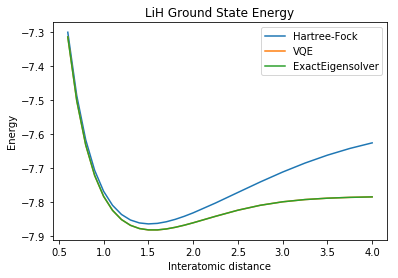

In [7]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right');